# Поиск самого прибыльного региона для добычи нефти

## Описание проекта

Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
* /datasets/geo_data_0.csv
* /datasets/geo_data_1.csv
* /datasets/geo_data_2.csv
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

## Условия задачи

* В данном учебном проекте необходимо использовать только Линейную Регрессию.
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Import

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phik
import scipy.stats as st
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler)
from sklearn.utils import shuffle

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.mode.chained_assignment = None

RANDOM_STATE = 42

In [8]:
base = 'C:/Users/anton/OneDrive/data_science/yandex_practicum/datasets/'
geo_data_0 = pd.read_csv(base + 'geo_data_0.csv')
geo_data_1 = pd.read_csv(base + 'geo_data_1.csv')
geo_data_2 = pd.read_csv(base + 'geo_data_2.csv')

## EDA

In [10]:
def info_func(data):
    print(data.info())
    
    print('Data Sample')
    display(data.head())
    print()
    
    print('Scatter Matrix')
    pd.plotting.scatter_matrix(data, figsize=(9,9))
    plt.show()
    
    print('Матрица кореляций')
    display(data.corr())

### Region 1

In [12]:
print(f'Количество дубликатов ID в датасете 0:', len(geo_data_0[geo_data_0['id'].duplicated()]))
print(f'Количество дубликатов ID в датасете 1:', len(geo_data_0[geo_data_1['id'].duplicated()]))
print(f'Количество дубликатов ID в датасете 2:', len(geo_data_0[geo_data_2['id'].duplicated()]))

Количество дубликатов ID в датасете 0: 10
Количество дубликатов ID в датасете 1: 4
Количество дубликатов ID в датасете 2: 4


В данных присутствуют задублированные id, которые имеют разные измеренные значения. Их немного, поэтому предлагаю удалить их.

Также нам не понадобится 'id' скважин

In [14]:
geo_data_0 = geo_data_0.drop_duplicates(subset='id', keep=False)
geo_data_1 = geo_data_1.drop_duplicates(subset='id', keep=False)
geo_data_2 = geo_data_2.drop_duplicates(subset='id', keep=False)

geo_data_0 = geo_data_0.drop('id', axis=1)
geo_data_1 = geo_data_1.drop('id', axis=1)
geo_data_2 = geo_data_2.drop('id', axis=1)

<class 'pandas.core.frame.DataFrame'>
Index: 99980 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99980 non-null  float64
 1   f1       99980 non-null  float64
 2   f2       99980 non-null  float64
 3   product  99980 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB
None
Data Sample


,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647



Scatter Matrix


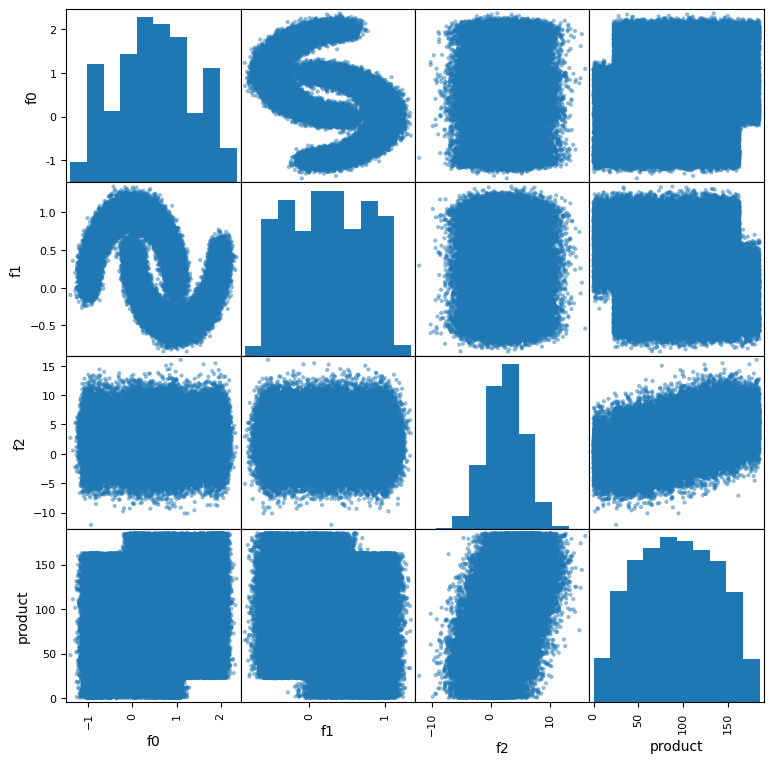

Матрица кореляций


,f0,f1,f2,product
f0,1.000000,-0.440724,-0.003204,0.143504
f1,-0.440724,1.000000,0.001783,-0.192338
f2,-0.003204,0.001783,1.000000,0.483628
product,0.143504,-0.192338,0.483628,1.000000


In [15]:
info_func(geo_data_0)

### Region 2

<class 'pandas.core.frame.DataFrame'>
Index: 99992 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99992 non-null  float64
 1   f1       99992 non-null  float64
 2   f2       99992 non-null  float64
 3   product  99992 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB
None
Data Sample


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305



Scatter Matrix


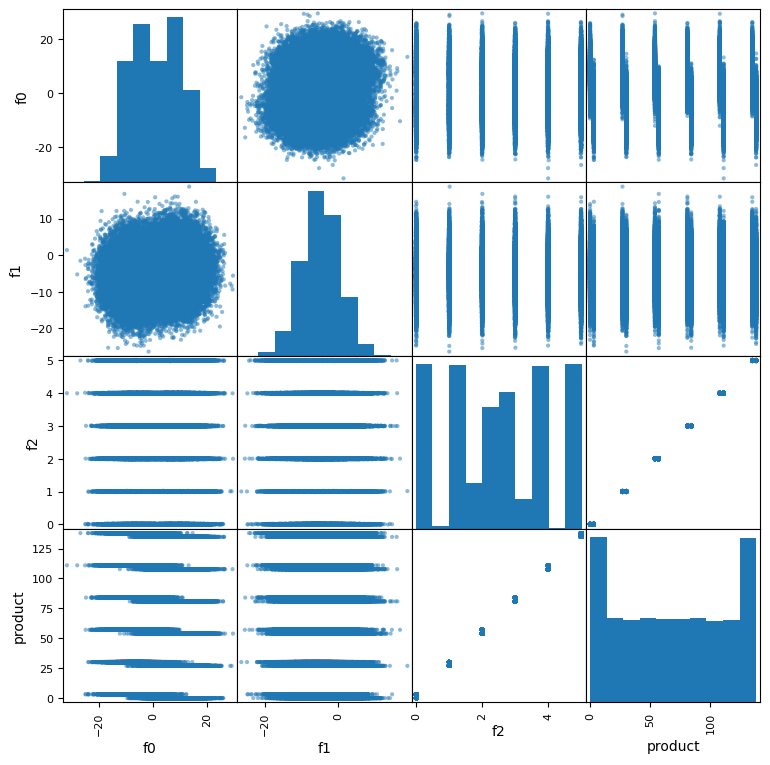

Матрица кореляций


,f0,f1,f2,product
f0,1.000000,0.182263,-0.001821,-0.030534
f1,0.182263,1.000000,-0.002608,-0.010167
f2,-0.001821,-0.002608,1.000000,0.999397
product,-0.030534,-0.010167,0.999397,1.000000


In [17]:
info_func(geo_data_1)

### Region 3

<class 'pandas.core.frame.DataFrame'>
Index: 99992 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99992 non-null  float64
 1   f1       99992 non-null  float64
 2   f2       99992 non-null  float64
 3   product  99992 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB
None
Data Sample


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746



Scatter Matrix


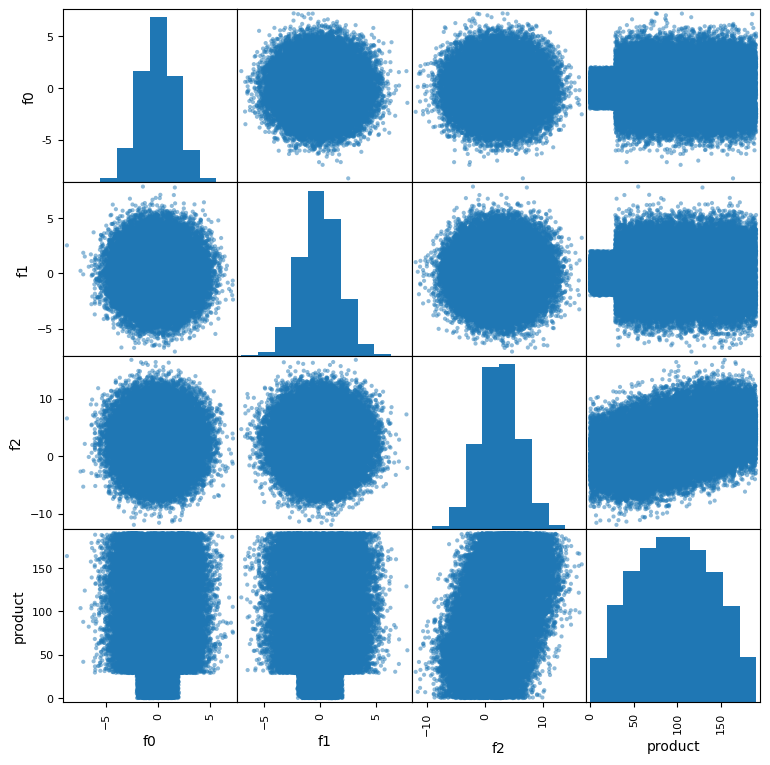

Матрица кореляций


,f0,f1,f2,product
f0,1.000000,0.000501,-0.000454,-0.001974
f1,0.000501,1.000000,0.000763,-0.001046
f2,-0.000454,0.000763,1.000000,0.445873
product,-0.001974,-0.001046,0.445873,1.000000


In [19]:
info_func(geo_data_2)

<div class="alert alert-info"> 
<b>Промежуточный вывод</b>
    
Датасет был сгенерирован синтетически, фичи никакой интерпретации не имеют, поэтому и данные выглядят странно. Работам с тем что есть.

## Расчет прибыли и рисков

In [22]:
# 500 точек, которые исследуют
QTTY_WELLS_INV = 500

# 200 выбирают для разработки
QTTY_WELLS_DEV = 200

# Общий бюджет на разработку
BUDGET = 10**10

# Цена барреля на момент исследования
BARREL_PRICE = 450

# Количество сырья, которо необходимо добыть в регионе для покрытия расходов
# C учетом, что в данных единицей количества сырья является 1000 баррелей
MIN_PRODUCTION = BUDGET / BARREL_PRICE / 1000

# Среднее количество сырья на скважину, необходимое для покрытия расходов
MIN_MEAN_PRODUCTION = MIN_PRODUCTION / QTTY_WELLS_DEV

print(f'''
Выбрано {QTTY_WELLS_INV} скважин для исследования
Выбрано {QTTY_WELLS_DEV} скважин для разработки
Общий бюджет на разработку составляет {BUDGET}$
Цена барреля на момент исследования составляет {BARREL_PRICE}$
Минимально необходимая добыча со всех скважин нужна {MIN_PRODUCTION:.2f} тыс. баррелей
Минимальная средняя добыча с одной скважины должна быть {MIN_MEAN_PRODUCTION:.2f} тыс. баррелей
''')

print(f"Средняя добыча в регионе 0 с одной скважины составляет: {geo_data_0['product'].mean():.2f}")
print(f"Средняя добыча в регионе 1 с одной скважины составляет: {geo_data_1['product'].mean():.2f}")
print(f"Средняя добыча в регионе 2 с одной скважины составляет: {geo_data_2['product'].mean():.2f}")


Выбрано 500 скважин для исследования
Выбрано 200 скважин для разработки
Общий бюджет на разработку составляет 10000000000$
Цена барреля на момент исследования составляет 450$
Минимально необходимая добыча со всех скважин нужна 22222.22 тыс. баррелей
Минимальная средняя добыча с одной скважины должна быть 111.11 тыс. баррелей

Средняя добыча в регионе 0 с одной скважины составляет: 92.50
Средняя добыча в регионе 1 с одной скважины составляет: 68.82
Средняя добыча в регионе 2 с одной скважины составляет: 95.00


По предварительным расчетам видно, что требуемые показатели добычи сильно выше средних по регионам. Применим нашу модель и технику bootstrap для выбора наилучших скважин.

## Обучение и проверка модели

План действий:
1. Разделить датасет на обучающую и тестовую выборки
2. Обучить линейную регрессию на обучающей выборке
3. Применить бутстрэп на тестовой выборке

Бутстрэп:

4. Рандомно выбрать 500 скважин из тестовой выборки
5. Предсказать добычу для этих 500 скважин
6. Выбрать 200 лучших по предсказаниям
7. Посчитать прибыль для выбранных 200

Повторить 1000 раз ...  
Таким образом получится распределение возможной прибыли для каждого региона.

8. Выбрать регионы, где убытки не превышают 2.5%
9. Среди выбранных выбрать регион с наивысшей средней прибылью

In [26]:
# Split
# Функция для разделения датасета сначала на target и features, а затем на train и valid
def get_train_valid(data):
    features = data.drop(['product'], axis=1)
    target = data['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target,
        test_size=0.25,
        random_state=RANDOM_STATE
    )
    
    features_valid = features_valid.reset_index(drop=True)
    target_valid = target_valid.reset_index(drop=True)
    
    return features_train, features_valid, target_train, target_valid

features_0_train, features_0_valid, target_0_train, target_0_valid = get_train_valid(geo_data_0)
features_1_train, features_1_valid, target_1_train, target_1_valid = get_train_valid(geo_data_1)
features_2_train, features_2_valid, target_2_train, target_2_valid = get_train_valid(geo_data_2)

print(features_0_train.shape, target_0_train.shape)
print(features_0_valid.shape, target_0_valid.shape)

(74985, 3) (74985,)
(24995, 3) (24995,)


In [27]:
# Scaler
scaler = StandardScaler()

features_0_train[['f0', 'f1', 'f2']] = scaler.fit_transform(features_0_train[['f0', 'f1', 'f2']])
features_0_valid[['f0', 'f1', 'f2']] = scaler.transform(features_0_valid[['f0', 'f1', 'f2']])

features_1_train[['f0', 'f1', 'f2']] = scaler.fit_transform(features_1_train[['f0', 'f1', 'f2']])
features_1_valid[['f0', 'f1', 'f2']] = scaler.transform(features_1_valid[['f0', 'f1', 'f2']])

features_2_train[['f0', 'f1', 'f2']] = scaler.fit_transform(features_2_train[['f0', 'f1', 'f2']])
features_2_valid[['f0', 'f1', 'f2']] = scaler.transform(features_2_valid[['f0', 'f1', 'f2']])

### Model

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns

class IncomeBootstrap:
    '''
    Class to calculate income distribution with bootstrap
    '''
    def __init__(self, model):
        '''
        Class input: a model that has methods .fit() and .predict()
        '''
        self.model = model
        return
    
    def fit(self, X, y):
        '''
        Input: X and y datasets to fit the model
        '''
        self.model.fit(X, y)
        return

    def get_incomes(self, X, y, btstr_samples=1000, n_random_pick=500, n_best_pick=200, budget=10**10, barrel_price=450):
        '''
        Input: X and y to run bootstrap with `btstr_samples` number of samples.
        Output: An array of possible incomes
        '''
        state = np.random.RandomState(42)
        y_pred = self.model.predict(X)
        y = y.values
        
        incomes = []
        for i in range(btstr_samples):
            random_indexes = state.choice(len(y), size=n_random_pick, replace=True)
            y_pred_sample = y_pred[random_indexes]
            y_sample = y[random_indexes]
            
            sorted_indexes = np.argsort(y_pred_sample)[::-1][:n_best_pick]
            top_n_product = y_sample[sorted_indexes].sum()
            
            income = top_n_product * 1000 * barrel_price - budget
            incomes.append(income)
        incomes = np.array(incomes)
        return incomes

    # Функция для построения отчета
    def summary_incomes(self, X, y, btstr_samples=1000, n_random_pick=500, n_best_pick=200, budget=10**10, barrel_price=450):
        '''
        Input: same as self.get_incomes()
        Output: None, displays a summary
        '''
        incomes = self.get_incomes(X, y, btstr_samples=btstr_samples, n_random_pick=n_random_pick, n_best_pick=n_best_pick, budget=budget, barrel_price=barrel_price)
        
        loss_prob = (incomes < 0).mean()

        sns.histplot(incomes, label='Income')
        plt.axvline(x=np.quantile(incomes, 0.025), linestyle='--', color='red', label='95% confidence interval')
        plt.axvline(x=np.quantile(incomes, 0.975), linestyle='--', color='red')
        plt.xlabel('Income, $')
        plt.title('Распределение возможной прибыли в регионе')
        plt.legend()
        plt.show()

        print(f'''
        Средняя прибыль составляет {incomes.mean():.0f}
        95% доверительный интервал находится от {np.quantile(incomes, 0.025):.0f} до {np.quantile(incomes, 0.975):.0f}
        Риск убытков составляет {loss_prob:.1%}
        ''')

### Baseline

Для бейзлайна можно проверить какая будет прибыль (или более вероятно - убытки), если все 200 скважин выбирать наугад.

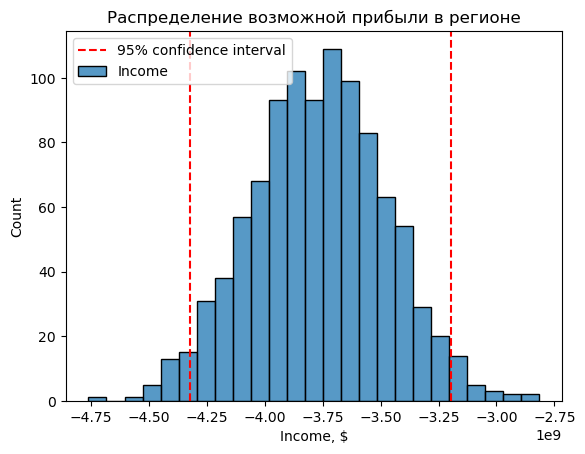


        Средняя прибыль составляет -3767801882
        95% доверительный интервал находится от -4321814552 до -3197179368
        Риск убытков составляет 100.0%
        


In [57]:
income_bootstrap = IncomeBootstrap(LinearRegression())

income_bootstrap.fit(features_1_train, target_1_train)
income_bootstrap.summary_incomes(features_1_valid, target_1_valid, n_random_pick=200, n_best_pick=200)

<div class="alert alert-info"> 
<b>Промежуточный вывод</b>

Если скважины выбирать наугад, то примерные убытки составят 3 - 4 миллиарда долларов

### Results

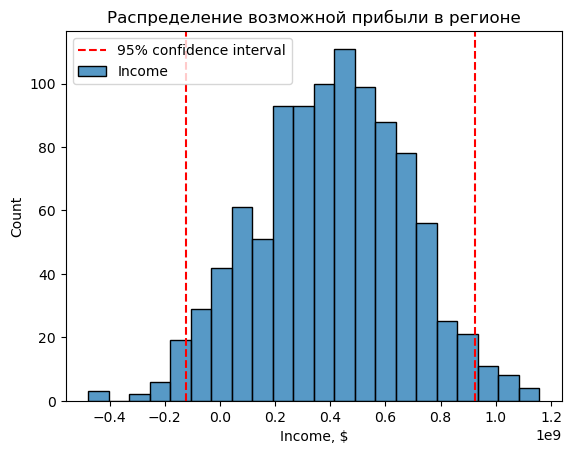


        Средняя прибыль составляет 405706853
        95% доверительный интервал находится от -121426874 до 923795255
        Риск убытков составляет 7.2%
        


In [61]:
income_bootstrap.fit(features_0_train, target_0_train)
income_bootstrap.summary_incomes(features_0_valid, target_0_valid)

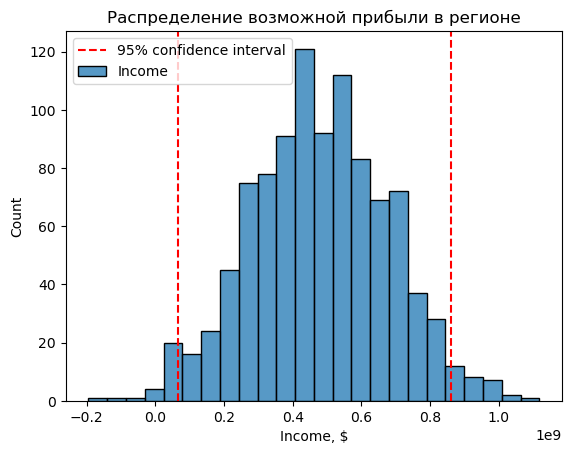


        Средняя прибыль составляет 478871449
        95% доверительный интервал находится от 65326280 до 861736054
        Риск убытков составляет 0.5%
        


In [63]:
income_bootstrap.fit(features_1_train, target_1_train)
income_bootstrap.summary_incomes(features_1_valid, target_1_valid)

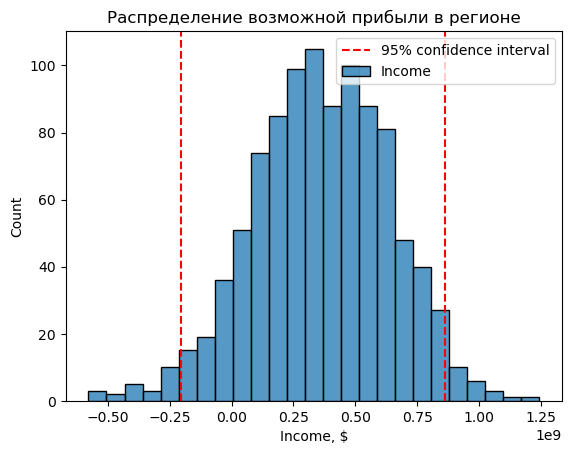


        Средняя прибыль составляет 363047927
        95% доверительный интервал находится от -206076347 до 862100486
        Риск убытков составляет 9.0%
        


In [65]:
income_bootstrap.fit(features_2_train, target_2_train)
income_bootstrap.summary_incomes(features_2_valid, target_2_valid)

<div class="alert alert-info"> 
<b>Промежуточный вывод</b>

Наименьший риск убытков мы получили в регионе "1" - 0.5%. Средняя прибыль для этого региона также наибольшая - 479 млн. Также, в регионе "1" 95% доверительный интервал прибыли полностью находится правее от нуля. Предполагаемый худший сценарий в этом регионе - прибыль около 65 млн.

## Вывод

<div class="alert alert-info"> 
<b>Вывод</b>

Было получено 3 датасета по 3 признака и 100 000 наблюдений в каждом. Данные использовались без предобработки.

Согласно условиям задачи был реализован следующий алгоритм для каждого региона:
1. Выбираем 500 рандомных скважин
2. Предсказываем для них предполагаемую выработку
3. Выбираем 200 лучших
4. Рассчитываем реальную прибыль
5. Повторяем 1000 раз при помощи техники Bootstrap

Бейзлайн - выбор 200 скважин наугад. Примерные убытки составляют 3 - 4 миллиарда долларов.
    
Расчетные убытки меньше условных 2.5% получились только в регионе 1, в остальных вероятность убытков 7% у региона 0 и 9% у региона 2. Средняя расчетная прибыль в регионе 1 составляет 478 871 449$